%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_aging/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
import diffxpy.api as de

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

array(['scran', 'SingleCellExperiment', 'SummarizedExperiment',
       'DelayedArray', 'BiocParallel', 'matrixStats', 'Biobase',
       'GenomicRanges', 'GenomeInfoDb', 'IRanges', 'S4Vectors',
       'BiocGenerics', 'parallel', 'stats4', 'Seurat', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U20')

In [8]:
from TenX_aging_misc_scripts_v1_0 import *
from TenX_aging_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [12]:
#exp_id = create_ID()

In [10]:
exp_id = '202111251525'
path_input = '/Users/simjoo/Projects/10X_aging/data_input/'
path_output = '/Users/simjoo/Projects/10X_aging/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_aging/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tissue = {'tumor_KP_AdSPCCre': '#33a02c','healthy': '#e31a1c',
               'tumor_KP_mScarlet':'#ff7f00','tumor_KP_mScarletOVA':'#6a3d9a', 'tumor_Elm4ALK':'#1f78b4'}
cmap_age = {'young': '#bababa', 'aged': '#4d4d4d'}
cmap_tumor_age = {'healthy_young':'#b2df8a', 'healthy_aged':'#33a02c', 
                  'tumor_KP_AdSPCCre_young':'#fb9a99', 'tumor_KP_AdSPCCre_aged':'#e31a1c',
                  'tumor_KP_mScarlet_young':'#fdbf6f', 'tumor_KP_mScarlet_aged':'#ff7f00',
                  'tumor_KP_mScarletOVA_young':'#cab2d6','tumor_KP_mScarletOVA_aged':'#6a3d9a',
                  'tumor_Elm4ALK_young':'#a6cee3','tumor_Elm4ALK_aged':'#1f78b4'}

# Initialize engines

In [12]:
c = Client()

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for bionut2400: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipyparallel/client/client.py:466: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@bionut2400')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_aging/scripts/v3/")')
dview.execute('from TenX_aging_misc_scripts_v1_0 import *')
dview.execute('from TenX_aging_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Compile data

## GH1529_YoungTumor

### Load data into AnnData format

In [15]:
_GH1529_YoungTumor = sc.read_10x_mtx('%s/20201211_Sample1_GH1529_YoungTumor_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_GH1529_YoungTumor.obs_names = [s.split('-')[0] for s in _GH1529_YoungTumor.obs_names]

In [16]:
_GH1529_YoungTumor.layers['raw'] = _GH1529_YoungTumor.X

In [17]:
X_GH1529_YoungTumor = _GH1529_YoungTumor[:,:-21]

### Add transgene counts to metadata

In [18]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [19]:
X_GH1529_YoungTumor.obs[tgs] = X_GH1529_YoungTumor[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [20]:
X_GH1529_YoungTumor = X_GH1529_YoungTumor[:,:-8]

### Assign hashes (using manual thresholding)

In [21]:
hashes = ['A0301_TotalSeqA',
          'A0302_TotalSeqA',
          'A0304_TotalSeqA']

In [22]:
H_GH1529_YoungTumor = _GH1529_YoungTumor[:,hashes]

In [23]:
H_GH1529_YoungTumor.X = H_GH1529_YoungTumor.X.todense()

In [24]:
pdH = sc2pd(H_GH1529_YoungTumor, 'X')

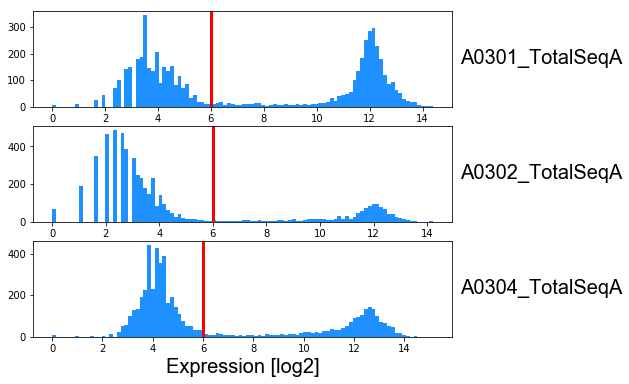

In [25]:
plot_hashes(pdH, thr = [6,6,6])

In [26]:
hashes_out = assign_hashes(pdH, [6,6,6])

In [27]:
X_GH1529_YoungTumor.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [28]:
X_GH1529_YoungTumor.obs['batch'] = 'GH1529_YoungTumor'
X_GH1529_YoungTumor.obs['sample'] = None
X_GH1529_YoungTumor.obs['mouse'] = 'GH1529'
X_GH1529_YoungTumor.obs['sex'] = 'F'
X_GH1529_YoungTumor.obs['tumor'] = 'KP'
X_GH1529_YoungTumor.obs['age'] = 'young'
X_GH1529_YoungTumor.obs['tumor*age'] = 'KP_young'
X_GH1529_YoungTumor.obs['tumor_stage'] = '17-18wk'

In [29]:
sample_GH1529 = {'A0301_TotalSeqA':'GH1529_KP_young1',
                 'A0302_TotalSeqA':'GH1529_KP_young2',
                 'A0304_TotalSeqA':'GH1529_KP_young3'}

In [30]:
X_GH1529_YoungTumor.obs['sample'] = [sample_GH1529[i] if i in sample_GH1529 else 'fail' for i in X_GH1529_YoungTumor.obs['hashID']]

In [31]:
Counter(X_GH1529_YoungTumor.obs['sample'])

Counter({'GH1529_KP_young1': 2434,
         'GH1529_KP_young2': 925,
         'fail': 583,
         'GH1529_KP_young3': 1523})

## GH2333_YoungHealthy

### Load data into AnnData format

In [32]:
_GH2333_YoungHealthy = sc.read_10x_mtx('%s/20201208_Sample2_GH2333_YoungHealthy_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_GH2333_YoungHealthy.obs_names = [s.split('-')[0] for s in _GH2333_YoungHealthy.obs_names]

In [33]:
_GH2333_YoungHealthy.layers['raw'] = _GH2333_YoungHealthy.X

In [34]:
X_GH2333_YoungHealthy = _GH2333_YoungHealthy

### Add transgene counts to metadata

In [35]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [36]:
X_GH2333_YoungHealthy.obs[tgs] = X_GH2333_YoungHealthy[:,tgs].X.todense()

In [37]:
X_GH2333_YoungHealthy = X_GH2333_YoungHealthy[:,:-8]

### No hashes

In [38]:
X_GH2333_YoungHealthy.obs['hashID'] = 'no_hash'

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [39]:
X_GH2333_YoungHealthy.obs['batch'] = 'GH2333_YoungHealthy'
X_GH2333_YoungHealthy.obs['sample'] = 'GH2333_healthy_young'
X_GH2333_YoungHealthy.obs['mouse'] = 'GH2333'
X_GH2333_YoungHealthy.obs['sex'] = 'M'
X_GH2333_YoungHealthy.obs['tumor'] = 'healthy'
X_GH2333_YoungHealthy.obs['age'] = 'young'
X_GH2333_YoungHealthy.obs['tumor*age'] = 'healthy_young'
X_GH2333_YoungHealthy.obs['tumor_stage'] = 'healthy'

## KW1536_AgedHealthy

### Load data into AnnData format

In [40]:
_KW1536_AgedHealthy = sc.read_10x_mtx('%s/20201208_Sample3_KW1536_AgedHealthy_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_KW1536_AgedHealthy.obs_names = [s.split('-')[0] for s in _KW1536_AgedHealthy.obs_names]

In [41]:
_KW1536_AgedHealthy.layers['raw'] = _KW1536_AgedHealthy.X

In [42]:
X_KW1536_AgedHealthy = _KW1536_AgedHealthy

### Add transgene counts to metadata

In [43]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [44]:
X_KW1536_AgedHealthy.obs[tgs] = X_KW1536_AgedHealthy[:,tgs].X.todense()

In [45]:
X_KW1536_AgedHealthy = X_KW1536_AgedHealthy[:,:-8]

### No hashes

In [46]:
X_KW1536_AgedHealthy.obs['hashID'] = 'no_hash'

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [47]:
X_KW1536_AgedHealthy.obs['batch'] = 'KW1536_AgedHealthy'
X_KW1536_AgedHealthy.obs['sample'] = 'KW1536_healthy_aged'
X_KW1536_AgedHealthy.obs['mouse'] = 'KW1536'
X_KW1536_AgedHealthy.obs['sex'] = 'M'
X_KW1536_AgedHealthy.obs['tumor'] = 'healthy'
X_KW1536_AgedHealthy.obs['age'] = 'aged'
X_KW1536_AgedHealthy.obs['tumor*age'] = 'healthy_aged'
X_KW1536_AgedHealthy.obs['tumor_stage'] = 'healthy'

## KW1537_AgedHealthy

### Load data into AnnData format

In [48]:
_KW1537_AgedHealthy = sc.read_10x_mtx('%s/20201208_Sample4_KW1537_AgedHealthy_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_KW1537_AgedHealthy.obs_names = [s.split('-')[0] for s in _KW1537_AgedHealthy.obs_names]

In [49]:
_KW1537_AgedHealthy.layers['raw'] = _KW1537_AgedHealthy.X

In [50]:
X_KW1537_AgedHealthy = _KW1537_AgedHealthy

### Add transgene counts to metadata

In [51]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [52]:
X_KW1537_AgedHealthy.obs[tgs] = X_KW1537_AgedHealthy[:,tgs].X.todense()

In [53]:
X_KW1537_AgedHealthy = X_KW1537_AgedHealthy[:,:-8]

### No hashes

In [54]:
X_KW1537_AgedHealthy.obs['hashID'] = 'no_hash'

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [55]:
X_KW1537_AgedHealthy.obs['batch'] = 'KW1537_AgedHealthy'
X_KW1537_AgedHealthy.obs['sample'] = 'KW1537_healthy_aged'
X_KW1537_AgedHealthy.obs['mouse'] = 'KW1537'
X_KW1537_AgedHealthy.obs['sex'] = 'M'
X_KW1537_AgedHealthy.obs['tumor'] = 'healthy'
X_KW1537_AgedHealthy.obs['age'] = 'aged'
X_KW1537_AgedHealthy.obs['tumor*age'] = 'healthy_aged'
X_KW1537_AgedHealthy.obs['tumor_stage'] = 'healthy'

## SM8822_AgedTumor

### Load data into AnnData format

In [56]:
_SM8822_AgedTumor = sc.read_10x_mtx('%s/20201211_Sample5_SM8822_AgedTumor_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_SM8822_AgedTumor.obs_names = [s.split('-')[0] for s in _SM8822_AgedTumor.obs_names]

In [57]:
_SM8822_AgedTumor.layers['raw'] = _SM8822_AgedTumor.X

In [58]:
X_SM8822_AgedTumor = _SM8822_AgedTumor[:,:-21]

### Add transgene counts to metadata

In [59]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [60]:
X_SM8822_AgedTumor.obs[tgs] = X_SM8822_AgedTumor[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [61]:
X_SM8822_AgedTumor = X_SM8822_AgedTumor[:,:-8]

### Assign hashes

In [62]:
hashes = ['A0301_TotalSeqA', 
          'A0302_TotalSeqA', 
          'A0303_TotalSeqA']

In [63]:
H_SM8822_AgedTumor = _SM8822_AgedTumor[:,hashes]

In [64]:
H_SM8822_AgedTumor.X = H_SM8822_AgedTumor.X.todense()

In [65]:
pdH = sc2pd(H_SM8822_AgedTumor, 'X')

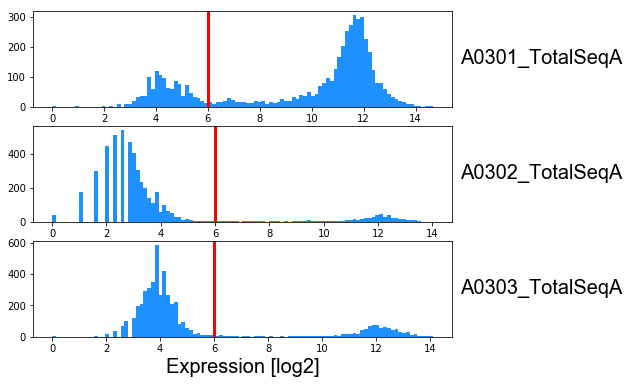

In [66]:
plot_hashes(pdH, thr = [6,6,6])

In [67]:
hashes_out = assign_hashes(pdH, [6,6,6])

In [68]:
X_SM8822_AgedTumor.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [69]:
X_SM8822_AgedTumor.obs['batch'] = 'SM8822_AgedTumor'
X_SM8822_AgedTumor.obs['sample'] = None
X_SM8822_AgedTumor.obs['mouse'] = 'SM8822'
X_SM8822_AgedTumor.obs['sex'] = 'F'
X_SM8822_AgedTumor.obs['tumor'] = 'KP'
X_SM8822_AgedTumor.obs['age'] = 'aged'
X_SM8822_AgedTumor.obs['tumor*age'] = 'KP_aged'
X_SM8822_AgedTumor.obs['tumor_stage'] = '17-18wk'

In [70]:
sample_SM8822 = {'A0301_TotalSeqA':'SM8822_KP_aged1',
                 'A0302_TotalSeqA':'SM8822_KP_aged2',
                 'A0303_TotalSeqA':'SM8822_KP_aged3'}

In [71]:
X_SM8822_AgedTumor.obs['sample'] = [sample_SM8822[i] if i in sample_SM8822 else 'fail' for i in X_SM8822_AgedTumor.obs['hashID']]

In [72]:
Counter(X_SM8822_AgedTumor.obs['sample'])

Counter({'fail': 425,
         'SM8822_KP_aged1': 3485,
         'SM8822_KP_aged2': 378,
         'SM8822_KP_aged3': 678})

## Y07_YoungHealthy

### Load data into AnnData format

In [73]:
_Y07_YoungHealthy = sc.read_10x_mtx('%s/20201208_Sample6_Y07_YoungHealthy_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_Y07_YoungHealthy.obs_names = [s.split('-')[0] for s in _Y07_YoungHealthy.obs_names]

In [74]:
_Y07_YoungHealthy.layers['raw'] = _Y07_YoungHealthy.X

In [75]:
X_Y07_YoungHealthy = _Y07_YoungHealthy

### Add transgene counts to metadata

In [76]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [77]:
X_Y07_YoungHealthy.obs[tgs] = X_Y07_YoungHealthy[:,tgs].X.todense()

In [78]:
X_Y07_YoungHealthy = X_Y07_YoungHealthy[:,:-8]

### No hashes

In [79]:
X_Y07_YoungHealthy.obs['hashID'] = 'no_hash'

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [80]:
X_Y07_YoungHealthy.obs['batch'] = 'Y07_YoungHealthy'
X_Y07_YoungHealthy.obs['sample'] = 'Y07_healthy_young'
X_Y07_YoungHealthy.obs['mouse'] = 'Y07'
X_Y07_YoungHealthy.obs['sex'] = 'M'
X_Y07_YoungHealthy.obs['tumor'] = 'healthy'
X_Y07_YoungHealthy.obs['age'] = 'young'
X_Y07_YoungHealthy.obs['tumor*age'] = 'healthy_young'
X_Y07_YoungHealthy.obs['tumor_stage'] = 'healthy'

# AY_SPCCRE_LUAD

### Load data into AnnData format

In [81]:
_AY_SPCCRE_LUAD = sc.read_10x_mtx('%s/20201211_Sample03-AY_SPCCRE_LUAD_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_AY_SPCCRE_LUAD.obs_names = [s.split('-')[0] for s in _AY_SPCCRE_LUAD.obs_names]

In [82]:
_AY_SPCCRE_LUAD.layers['raw'] = _AY_SPCCRE_LUAD.X

In [83]:
X_AY_SPCCRE_LUAD = _AY_SPCCRE_LUAD[:,:-13]

### Add transgene counts to metadata

In [84]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [85]:
X_AY_SPCCRE_LUAD.obs[tgs] = X_AY_SPCCRE_LUAD[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [86]:
X_AY_SPCCRE_LUAD = X_AY_SPCCRE_LUAD[:,:-8]

### Assign hashes

In [87]:
hashes = ['HTO3_CiteSeq',
          'HTO4_CiteSeq',
          'HTO5_CiteSeq',
          'HTO6_CiteSeq',
          'HTO7_CiteSeq',
          'HTO8_CiteSeq']

In [88]:
H_AY_SPCCRE_LUAD = _AY_SPCCRE_LUAD[:,hashes]

In [89]:
H_AY_SPCCRE_LUAD.X = H_AY_SPCCRE_LUAD.X.todense()

In [90]:
pdH = sc2pd(H_AY_SPCCRE_LUAD, 'X')

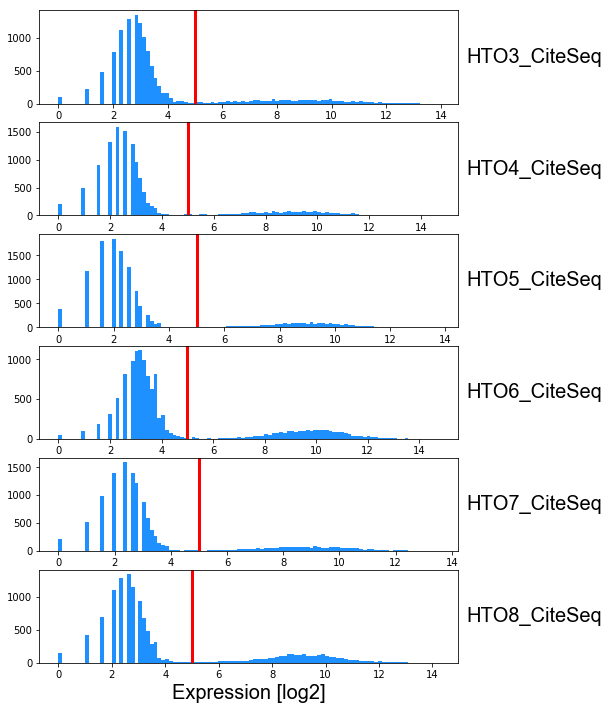

In [91]:
plot_hashes(pdH, thr = [5,5,5,5,5,5])

In [92]:
hashes_out = assign_hashes(pdH, thr = [5,5,5,5,5,5])

In [93]:
X_AY_SPCCRE_LUAD.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [94]:
X_AY_SPCCRE_LUAD.obs['batch'] = 'AY_SPCCRE_LUAD'
X_AY_SPCCRE_LUAD.obs['sample'] = None
X_AY_SPCCRE_LUAD.obs['mouse'] = None
X_AY_SPCCRE_LUAD.obs['sex'] = 'M'
X_AY_SPCCRE_LUAD.obs['tumor'] = 'KP'
X_AY_SPCCRE_LUAD.obs['age'] = None
X_AY_SPCCRE_LUAD.obs['tumor*age'] = None
X_AY_SPCCRE_LUAD.obs['tumor_stage'] = '17-18wk'

In [95]:
sample03 = {'HTO3_CiteSeq':'SM8593_KP_aged',
            'HTO4_CiteSeq':'OG1772_KP_young',
            'HTO5_CiteSeq':'OG1775_KP_young',
            'HTO6_CiteSeq':'OG1777_KP_young',
            'HTO7_CiteSeq':'SM8578_KP_aged',
            'HTO8_CiteSeq':'SM8588_KP_aged'}

In [96]:
X_AY_SPCCRE_LUAD.obs['sample'] = [sample03[i] if i in sample03 else 'fail' for i in X_AY_SPCCRE_LUAD.obs['hashID']]

In [97]:
mouse03 = {'HTO3_CiteSeq':'SM8593',
           'HTO4_CiteSeq':'OG1772',
           'HTO5_CiteSeq':'OG1775',
           'HTO6_CiteSeq':'OG1777',
           'HTO7_CiteSeq':'SM8578',
           'HTO8_CiteSeq':'SM8588'}

In [98]:
X_AY_SPCCRE_LUAD.obs['mouse'] = [mouse03[i] if i in mouse03 else 'fail' for i in X_AY_SPCCRE_LUAD.obs['hashID']]

In [99]:
age03 = {'HTO3_CiteSeq':'aged',
          'HTO4_CiteSeq':'young',
          'HTO5_CiteSeq':'young',
          'HTO6_CiteSeq':'young',
          'HTO7_CiteSeq':'aged',
          'HTO8_CiteSeq':'aged'}

In [100]:
X_AY_SPCCRE_LUAD.obs['age'] = [age03[i] if i in age03 else 'fail' for i in X_AY_SPCCRE_LUAD.obs['hashID']]

In [101]:
X_AY_SPCCRE_LUAD.obs['tumor*age'] = ['KP_%s' % i for i in X_AY_SPCCRE_LUAD.obs['age']]

In [102]:
Counter(X_AY_SPCCRE_LUAD.obs['sample'])

Counter({'fail': 2410,
         'SM8588_KP_aged': 2210,
         'OG1772_KP_young': 1373,
         'OG1777_KP_young': 1984,
         'OG1775_KP_young': 1470,
         'SM8593_KP_aged': 1227,
         'SM8578_KP_aged': 1513})

# 20200710 (XZ-513)

### Load data into AnnData format

In [103]:
_071020_A_YLUAD = sc.read_10x_mtx('%s/20201123_071020_A_YLUAD_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_071020_A_YLUAD.obs_names = [s.split('-')[0] for s in _071020_A_YLUAD.obs_names]

In [104]:
_071020_A_YLUAD.layers['raw'] = _071020_A_YLUAD.X

In [105]:
X_071020_A_YLUAD = _071020_A_YLUAD[:,:-9]

### Add transgene counts to metadata

In [106]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [107]:
X_071020_A_YLUAD.obs[tgs] = X_071020_A_YLUAD[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [108]:
X_071020_A_YLUAD = X_071020_A_YLUAD[:,:-8]

### Assign hashes

In [109]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB',]

In [110]:
H_071020_A_YLUAD = _071020_A_YLUAD[:,hashes]

In [111]:
H_071020_A_YLUAD.X = H_071020_A_YLUAD.X.todense()

In [112]:
pdH = sc2pd(H_071020_A_YLUAD, 'X')

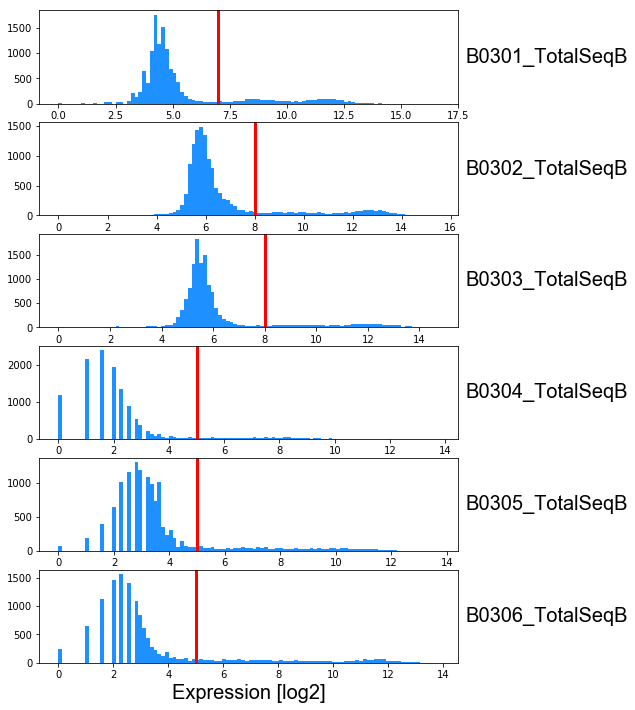

In [113]:
plot_hashes(pdH, thr = [7,8,8,5,5,5])

In [114]:
hashes_out = assign_hashes(pdH, thr = [7,8,8,5,5,5])

In [115]:
X_071020_A_YLUAD.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [116]:
X_071020_A_YLUAD.obs['batch'] = '071020_A_YLUAD'
X_071020_A_YLUAD.obs['sample'] = None
X_071020_A_YLUAD.obs['mouse'] = None
X_071020_A_YLUAD.obs['sex'] = None
X_071020_A_YLUAD.obs['tumor'] = 'KP'
X_071020_A_YLUAD.obs['age'] = None
X_071020_A_YLUAD.obs['tumor*age'] = None
X_071020_A_YLUAD.obs['tumor_stage'] = '19-20wk'

In [117]:
sample_071020 = {'B0301_TotalSeqB':'GH1123_KP_aged',
                 'B0302_TotalSeqB':'GH1338_KP_aged',
                 'B0303_TotalSeqB':'SM8826_KP_aged',
                 'B0304_TotalSeqB':'AD1003_KP_young',
                 'B0305_TotalSeqB':'AB1781_KP_young',
                 'B0306_TotalSeqB':'AC1370_KP_young'}

In [118]:
X_071020_A_YLUAD.obs['sample'] = [sample_071020[i] if i in sample_071020 else 'fail' for i in X_071020_A_YLUAD.obs['hashID']]

In [119]:
mouse_071020 = {'B0301_TotalSeqB':'GH1123',
                 'B0302_TotalSeqB':'GH1338',
                 'B0303_TotalSeqB':'SM8826',
                 'B0304_TotalSeqB':'AD1003',
                 'B0305_TotalSeqB':'AB1781',
                 'B0306_TotalSeqB':'AC1370'}

In [120]:
X_071020_A_YLUAD.obs['mouse'] = [mouse_071020[i] if i in mouse_071020 else 'fail' for i in X_071020_A_YLUAD.obs['hashID']]

In [121]:
sex_071020 = {'B0301_TotalSeqB':'F',
              'B0302_TotalSeqB':'M',
              'B0303_TotalSeqB':'M',
              'B0304_TotalSeqB':'F',
              'B0305_TotalSeqB':'M',
              'B0306_TotalSeqB':'F'}

In [122]:
X_071020_A_YLUAD.obs['sex'] = [sex_071020[i] if i in sex_071020 else 'fail' for i in X_071020_A_YLUAD.obs['hashID']]

In [123]:
age_071020 = {'B0301_TotalSeqB':'aged',
                 'B0302_TotalSeqB':'aged',
                 'B0303_TotalSeqB':'aged',
                 'B0304_TotalSeqB':'young',
                 'B0305_TotalSeqB':'young',
                 'B0306_TotalSeqB':'young'}

In [124]:
X_071020_A_YLUAD.obs['age'] = [age_071020[i] if i in age_071020 else 'fail' for i in X_071020_A_YLUAD.obs['hashID']]

In [125]:
X_071020_A_YLUAD.obs['tumor*age'] = ['KP_%s' % i for i in X_071020_A_YLUAD.obs['age']]

In [126]:
Counter(X_071020_A_YLUAD.obs['sample'])

Counter({'GH1123_KP_aged': 1738,
         'GH1338_KP_aged': 1620,
         'fail': 4456,
         'AC1370_KP_young': 1689,
         'SM8826_KP_aged': 1412,
         'AD1003_KP_young': 985,
         'AB1781_KP_young': 1324})

# 20200713 (XZ-514)

### Load data into AnnData format

In [127]:
_071320_A_YLUAD = sc.read_10x_mtx('%s/20201123_071320_A_YLUAD_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_071320_A_YLUAD.obs_names = [s.split('-')[0] for s in _071320_A_YLUAD.obs_names]

In [128]:
_071320_A_YLUAD.layers['raw'] = _071320_A_YLUAD.X

In [129]:
X_071320_A_YLUAD = _071320_A_YLUAD[:,:-9]

### Add transgene counts to metadata

In [130]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [131]:
X_071320_A_YLUAD.obs[tgs] = X_071320_A_YLUAD[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [132]:
X_071320_A_YLUAD = X_071320_A_YLUAD[:,:-8]

### Assign hashes

In [133]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB']

In [134]:
H_071320_A_YLUAD = _071320_A_YLUAD[:,hashes]

In [135]:
H_071320_A_YLUAD.X = H_071320_A_YLUAD.X.todense()

In [136]:
pdH = sc2pd(H_071320_A_YLUAD, 'X')

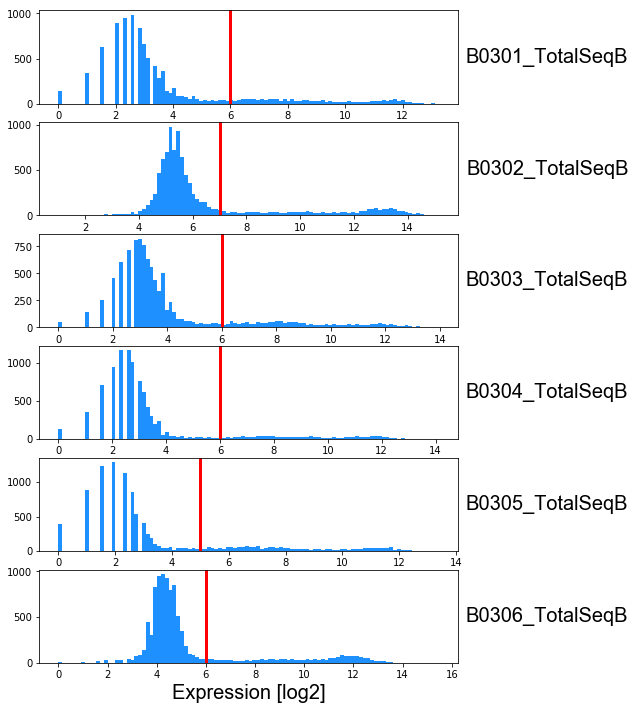

In [137]:
plot_hashes(pdH, thr = [6,7,6,6,5,6])

In [138]:
hashes_out = assign_hashes(pdH, [6,7,6,6,5,6])

In [139]:
X_071320_A_YLUAD.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [140]:
X_071320_A_YLUAD.obs['batch'] = '071320_A_YLUAD'
X_071320_A_YLUAD.obs['sample'] = None
X_071320_A_YLUAD.obs['mouse'] = None
X_071320_A_YLUAD.obs['sex'] = None
X_071320_A_YLUAD.obs['tumor'] = None
X_071320_A_YLUAD.obs['age'] = None
X_071320_A_YLUAD.obs['tumor*age'] = None
X_071320_A_YLUAD.obs['tumor_stage'] = '19-20wk'

In [141]:
sample_071320 = {'B0301_TotalSeqB':'GH1379_KPL_aged',
                 'B0302_TotalSeqB':'GH1536_KPL_aged',
                 'B0303_TotalSeqB':'GH1094_KPT_aged',
                 'B0304_TotalSeqB':'AD1114_KPL_young',
                 'B0305_TotalSeqB':'AD1002_KP_young',
                 'B0306_TotalSeqB':'AD1112_KPL_young'}

In [142]:
X_071320_A_YLUAD.obs['sample'] = [sample_071320[i] if i in sample_071320 else 'fail' for i in X_071320_A_YLUAD.obs['hashID']]

In [143]:
mouse_071320 = {'B0301_TotalSeqB':'GH1379',
                 'B0302_TotalSeqB':'GH1536',
                 'B0303_TotalSeqB':'GH1094',
                 'B0304_TotalSeqB':'AD1114',
                 'B0305_TotalSeqB':'AD1002',
                 'B0306_TotalSeqB':'AD1112'}

In [144]:
X_071320_A_YLUAD.obs['mouse'] = [mouse_071320[i] if i in mouse_071320 else 'fail' for i in X_071320_A_YLUAD.obs['hashID']]

In [145]:
sex_071320 = {'B0301_TotalSeqB':'M',
              'B0302_TotalSeqB':'M',
              'B0303_TotalSeqB':'M',
              'B0304_TotalSeqB':'F',
              'B0305_TotalSeqB':'M',
              'B0306_TotalSeqB':'M'}

In [146]:
X_071320_A_YLUAD.obs['sex'] = [sex_071320[i] if i in sex_071320 else 'fail' for i in X_071320_A_YLUAD.obs['hashID']]

In [147]:
tumor_071320 = {'B0301_TotalSeqB':'KPL',
              'B0302_TotalSeqB':'KPL',
              'B0303_TotalSeqB':'KPT',
              'B0304_TotalSeqB':'KPL',
              'B0305_TotalSeqB':'KP',
              'B0306_TotalSeqB':'KPL'}

In [148]:
X_071320_A_YLUAD.obs['tumor'] = [tumor_071320[i] if i in tumor_071320 else 'fail' for i in X_071320_A_YLUAD.obs['hashID']]

In [149]:
age_071320 = {'B0301_TotalSeqB':'aged',
                 'B0302_TotalSeqB':'aged',
                 'B0303_TotalSeqB':'aged',
                 'B0304_TotalSeqB':'young',
                 'B0305_TotalSeqB':'young',
                 'B0306_TotalSeqB':'young'}

In [150]:
X_071320_A_YLUAD.obs['age'] = [age_071320[i] if i in age_071320 else 'fail' for i in X_071320_A_YLUAD.obs['hashID']]

In [151]:
X_071320_A_YLUAD.obs['tumor*age'] = ['%s_%s' % (X_071320_A_YLUAD.obs['tumor'][i], X_071320_A_YLUAD.obs['age'][i]) for i in X_071320_A_YLUAD.obs_names]

In [152]:
Counter(X_071320_A_YLUAD.obs['sample'])

Counter({'AD1002_KP_young': 1310,
         'AD1112_KPL_young': 1194,
         'fail': 3245,
         'GH1094_KPT_aged': 941,
         'GH1536_KPL_aged': 1362,
         'GH1379_KPL_aged': 1004,
         'AD1114_KPL_young': 788})

# 20200826

### Load data into AnnData format

In [153]:
_20200826 = sc.read_10x_mtx('%s/20201214_20200826_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_20200826.obs_names = [s.split('-')[0] for s in _20200826.obs_names]

In [154]:
_20200826.layers['raw'] = _20200826.X

In [155]:
X_20200826 = _20200826[:,:-9]

### Add transgene counts to metadata

In [156]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [157]:
X_20200826.obs[tgs] = X_20200826[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [158]:
X_20200826 = X_20200826[:,:-8]

### Assign hashes

In [159]:
hashes = ['B0304_TotalSeqB',
          'B0305_TotalSeqB',
          'B0303_TotalSeqB',
          'B0306_TotalSeqB']

In [160]:
H_20200826 = _20200826[:,hashes]

In [161]:
H_20200826.X = H_20200826.X.todense()

In [162]:
pdH = sc2pd(H_20200826, 'X')

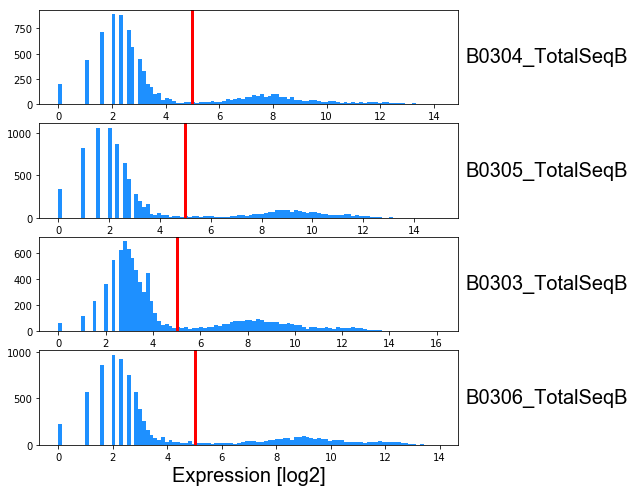

In [163]:
plot_hashes(pdH, thr = [5,5,5,5])

In [164]:
hashes_out = assign_hashes(pdH, [5,5,5,5])

In [165]:
X_20200826.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [166]:
X_20200826.obs['batch'] = '20200826'
X_20200826.obs['sample'] = None
X_20200826.obs['mouse'] = None
X_20200826.obs['sex'] = 'F'
X_20200826.obs['tumor'] = 'healthy'
X_20200826.obs['age'] = None
X_20200826.obs['tumor*age'] = None
X_20200826.obs['tumor_stage'] = 'healthy'

In [167]:
sample_20200826 = {'B0303_TotalSeqB':'1095_healthy_young',
                   'B0306_TotalSeqB':'1108_healthy_aged'}

In [168]:
X_20200826.obs['sample'] = [sample_20200826[i] if i in sample_20200826 else 'fail' for i in X_20200826.obs['hashID']]

In [169]:
mouse_20200826 = {'B0303_TotalSeqB':'1095',
                  'B0306_TotalSeqB':'1108'}

In [170]:
X_20200826.obs['mouse'] = [mouse_20200826[i] if i in mouse_20200826 else 'fail' for i in X_20200826.obs['hashID']]

In [171]:
age_20200826 = {'B0303_TotalSeqB':'young',
                'B0306_TotalSeqB':'aged'}

In [172]:
X_20200826.obs['age'] = [age_20200826[i] if i in age_20200826 else 'fail' for i in X_20200826.obs['hashID']]

In [173]:
X_20200826.obs['tumor*age'] = ['healthy_%s' % i for i in X_20200826.obs['age']]

In [174]:
Counter(X_20200826.obs['sample'])

Counter({'fail': 4852, '1108_healthy_aged': 1784, '1095_healthy_young': 1802})

# 20200901

### Load data into AnnData format

In [175]:
_20200901 = sc.read_10x_mtx('%s/20201214_20200901_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_20200901.obs_names = [s.split('-')[0] for s in _20200901.obs_names]

In [176]:
_20200901.layers['raw'] = _20200901.X

In [177]:
X_20200901 = _20200901[:,:-9]

### Add transgene counts to metadata

In [178]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [179]:
X_20200901.obs[tgs] = X_20200901[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [180]:
X_20200901 = X_20200901[:,:-8]

### Assign hashes

In [181]:
hashes = ['B0308_TotalSeqB',
          'B0309_TotalSeqB',
          'B0307_TotalSeqB',
          'B0303_TotalSeqB']

In [182]:
H_20200901 = _20200901[:,hashes]

In [183]:
H_20200901.X = H_20200901.X.todense()

In [184]:
pdH = sc2pd(H_20200901, 'X')

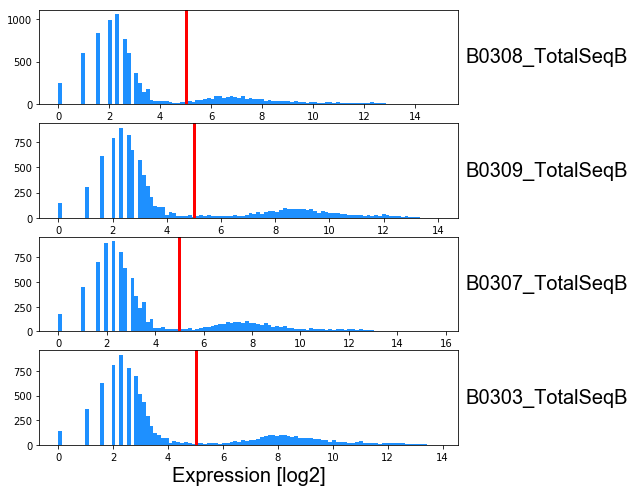

In [185]:
plot_hashes(pdH, thr = [5,5,5,5])

In [186]:
hashes_out = assign_hashes(pdH, [5,5,5,5])

In [187]:
X_20200901.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [188]:
X_20200901.obs['batch'] = '20200901'
X_20200901.obs['sample'] = None
X_20200901.obs['mouse'] = None
X_20200901.obs['sex'] = 'M'
X_20200901.obs['tumor'] = 'healthy'
X_20200901.obs['age'] = None
X_20200901.obs['tumor*age'] = None
X_20200901.obs['tumor_stage'] = 'healthy'

In [189]:
sample_20200901 = {'B0307_TotalSeqB':'1103_healthy_young',
                   'B0303_TotalSeqB':'1113_healthy_aged'}

In [190]:
X_20200901.obs['sample'] = [sample_20200901[i] if i in sample_20200901 else 'fail' for i in X_20200901.obs['hashID']]

In [191]:
mouse_20200901 = {'B0307_TotalSeqB':'1103',
                  'B0303_TotalSeqB':'1113'}

In [192]:
X_20200901.obs['mouse'] = [mouse_20200901[i] if i in mouse_20200901 else 'fail' for i in X_20200901.obs['hashID']]

In [193]:
age_20200901 = {'B0307_TotalSeqB':'young',
                'B0303_TotalSeqB':'aged'}

In [194]:
X_20200901.obs['age'] = [age_20200901[i] if i in age_20200901 else 'fail' for i in X_20200901.obs['hashID']]

In [195]:
X_20200901.obs['tumor*age'] = ['healthy_%s' % i for i in X_20200901.obs['age']]

In [196]:
Counter(X_20200901.obs['sample'])

Counter({'1113_healthy_aged': 1895, 'fail': 5033, '1103_healthy_young': 1759})

# XZ-1344_20211018

### Load data into AnnData format

In [197]:
_XZ1344_20211018 = sc.read_10x_mtx('%s/20211119_XZ-1344_20211018_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_XZ1344_20211018.obs_names = [s.split('-')[0] for s in _XZ1344_20211018.obs_names]

In [198]:
_XZ1344_20211018.layers['raw'] = _XZ1344_20211018.X

In [199]:
X_XZ1344_20211018 = _XZ1344_20211018[:,:-9]

### Add transgene counts to metadata

In [200]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [201]:
X_XZ1344_20211018.obs[tgs] = X_XZ1344_20211018[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [202]:
X_XZ1344_20211018 = X_XZ1344_20211018[:,:-8]

### Assign hashes

In [203]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB',]

In [204]:
H_XZ1344_20211018 = _XZ1344_20211018[:,hashes]

In [205]:
pdH = sc2pd(H_XZ1344_20211018, 'X')

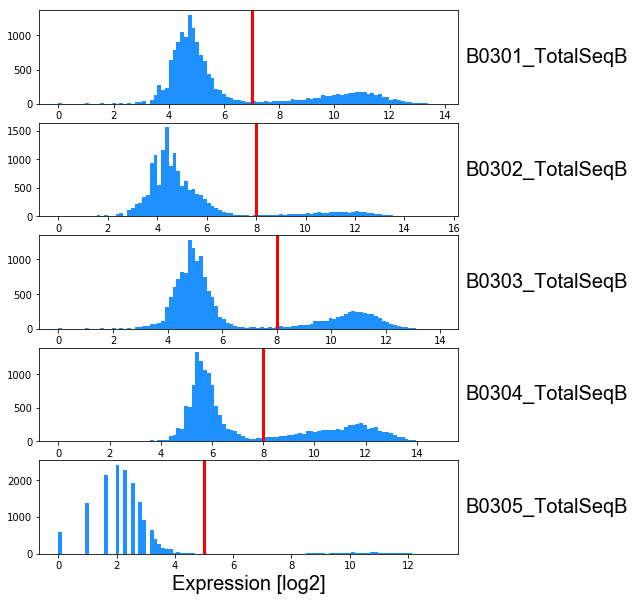

In [206]:
plot_hashes(pdH, thr = [7,8,8,8,5])

In [207]:
hashes_out = assign_hashes(pdH, [7,8,8,8,5])

In [208]:
X_XZ1344_20211018.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [209]:
X_XZ1344_20211018.obs['batch'] = 'XZ1344_20211018'
X_XZ1344_20211018.obs['sample'] = None
X_XZ1344_20211018.obs['mouse'] = None
X_XZ1344_20211018.obs['sex'] = 'M'
X_XZ1344_20211018.obs['tumor'] = None
X_XZ1344_20211018.obs['age'] = None
X_XZ1344_20211018.obs['tumor*age'] = None
X_XZ1344_20211018.obs['tumor_stage'] = '12wk'

In [210]:
sample_XZ1344_20211018 = {'B0301_TotalSeqB':'AB1424_KPL_aged',
                          'B0302_TotalSeqB':'AB1428_KPLR_aged',
                          'B0303_TotalSeqB':'AL1722_KPR_young',
                          'B0304_TotalSeqB':'AL1773_KPR_young',
                          'B0305_TotalSeqB':'AL1777_KPR_young',}

In [211]:
X_XZ1344_20211018.obs['sample'] = [sample_XZ1344_20211018[i] if i in sample_XZ1344_20211018 else 'fail' for i in X_XZ1344_20211018.obs['hashID']]

In [212]:
mouse_XZ1344_20211018 = {'B0301_TotalSeqB':'AB1424',
                         'B0302_TotalSeqB':'AB1428',
                         'B0303_TotalSeqB':'AL1722',
                         'B0304_TotalSeqB':'AL1773',
                         'B0305_TotalSeqB':'AL1777',}

In [213]:
X_XZ1344_20211018.obs['mouse'] = [mouse_XZ1344_20211018[i] if i in mouse_XZ1344_20211018 else 'fail' for i in X_XZ1344_20211018.obs['hashID']]

In [214]:
tumor_XZ1344_20211018 = {'B0301_TotalSeqB':'KPL',
                         'B0302_TotalSeqB':'KPLR',
                         'B0303_TotalSeqB':'KPR',
                         'B0304_TotalSeqB':'KPR',
                         'B0305_TotalSeqB':'KPR',}

In [215]:
X_XZ1344_20211018.obs['tumor'] = [tumor_XZ1344_20211018[i] if i in tumor_XZ1344_20211018 else 'fail' for i in X_XZ1344_20211018.obs['hashID']]

In [216]:
age_XZ1344_20211018 = {'B0301_TotalSeqB':'aged',
                       'B0302_TotalSeqB':'aged',
                       'B0303_TotalSeqB':'young',
                       'B0304_TotalSeqB':'young',
                       'B0305_TotalSeqB':'young'}

In [217]:
X_XZ1344_20211018.obs['age'] = [age_XZ1344_20211018[i] if i in age_XZ1344_20211018 else 'fail' for i in X_XZ1344_20211018.obs['hashID']]

In [218]:
X_XZ1344_20211018.obs['tumor*age'] = ['%s_%s' % (X_XZ1344_20211018.obs['tumor'][i], X_XZ1344_20211018.obs['age'][i]) for i in X_XZ1344_20211018.obs_names]

In [219]:
Counter(X_XZ1344_20211018.obs['sample'])

Counter({'AL1722_KPR_young': 3282,
         'AL1773_KPR_young': 4526,
         'AB1428_KPLR_aged': 1447,
         'AB1424_KPL_aged': 2992,
         'fail': 2883,
         'AL1777_KPR_young': 535})

# XZ-1345_20211019

### Load data into AnnData format

In [220]:
_XZ1345_20211019 = sc.read_10x_mtx('%s/20211119_XZ-1345_20211019_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_XZ1345_20211019 .obs_names = [s.split('-')[0] for s in _XZ1345_20211019.obs_names]

In [221]:
_XZ1345_20211019.layers['raw'] = _XZ1345_20211019.X

In [222]:
X_XZ1345_20211019 = _XZ1345_20211019[:,:-9]

### Add transgene counts to metadata

In [223]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [224]:
X_XZ1345_20211019.obs[tgs] = X_XZ1345_20211019[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [225]:
X_XZ1345_20211019 = X_XZ1345_20211019[:,:-8]

### Assign hashes

In [226]:
hashes = ['B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB',
          'B0310_TotalSeqB']

In [227]:
H_XZ1345_20211019 = _XZ1345_20211019[:,hashes]

In [228]:
pdH = sc2pd(H_XZ1345_20211019, 'X')

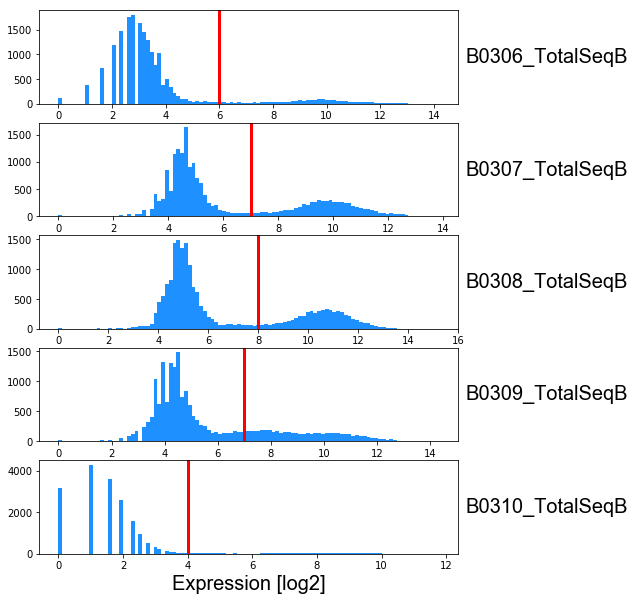

In [229]:
plot_hashes(pdH, thr = [6,7,8,7,4])

In [230]:
hashes_out = assign_hashes(pdH, [6,7,8,7,4])

In [231]:
X_XZ1345_20211019.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [232]:
X_XZ1345_20211019.obs['batch'] = 'XZ1345_20211019'
X_XZ1345_20211019.obs['sample'] = None
X_XZ1345_20211019.obs['mouse'] = None
X_XZ1345_20211019.obs['sex'] = 'M'
X_XZ1345_20211019.obs['tumor'] = 'KPR'
X_XZ1345_20211019.obs['age'] = None
X_XZ1345_20211019.obs['tumor*age'] = None
X_XZ1345_20211019.obs['tumor_stage'] = '12wk'

In [233]:
sample_XZ1345_20211019 = {'B0306_TotalSeqB':'AC1661_KPR_aged',
                          'B0307_TotalSeqB':'AC1662_KPR_aged',
                          'B0308_TotalSeqB':'AL1807_KPR_young',
                          'B0309_TotalSeqB':'AL1808_KPR_young'}

In [234]:
X_XZ1345_20211019.obs['sample'] = [sample_XZ1345_20211019[i] if i in sample_XZ1345_20211019 else 'fail' for i in X_XZ1345_20211019.obs['hashID']]

In [235]:
mouse_XZ1345_20211019 = {'B0306_TotalSeqB':'AC1661',
                         'B0307_TotalSeqB':'AC1662',
                         'B0308_TotalSeqB':'AL1807',
                         'B0309_TotalSeqB':'AL1808',}

In [236]:
X_XZ1345_20211019.obs['mouse'] = [mouse_XZ1345_20211019[i] if i in mouse_XZ1345_20211019 else 'fail' for i in X_XZ1345_20211019.obs['hashID']]

In [237]:
age_XZ1345_20211019 = {'B0306_TotalSeqB':'aged',
                       'B0307_TotalSeqB':'aged',
                       'B0308_TotalSeqB':'young',
                       'B0309_TotalSeqB':'young'}

In [238]:
X_XZ1345_20211019.obs['age'] = [age_XZ1345_20211019[i] if i in age_XZ1345_20211019 else 'fail' for i in X_XZ1345_20211019.obs['hashID']]

In [239]:
X_XZ1345_20211019.obs['tumor*age'] = ['KPR_%s' % i for i in X_XZ1345_20211019.obs['age']]

In [240]:
Counter(X_XZ1345_20211019.obs['sample'])

Counter({'fail': 5080,
         'AC1661_KPR_aged': 1416,
         'AL1807_KPR_young': 4362,
         'AL1808_KPR_young': 3622,
         'AC1662_KPR_aged': 4589})

# XZ-1450_20211210

### Load data into AnnData format

In [241]:
_XZ1450_20211210 = sc.read_10x_mtx('%s/20220112_XZ-1450_20211210_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_XZ1450_20211210 .obs_names = [s.split('-')[0] for s in _XZ1450_20211210.obs_names]

In [242]:
_XZ1450_20211210.layers['raw'] = _XZ1450_20211210.X

In [243]:
X_XZ1450_20211210 = _XZ1450_20211210[:,:-9]

### Add transgene counts to metadata

In [244]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [245]:
X_XZ1450_20211210.obs[tgs] = X_XZ1450_20211210[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [246]:
X_XZ1450_20211210 = X_XZ1450_20211210[:,:-8]

### Assign hashes

In [247]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0305_TotalSeqB',
          'B0306_TotalSeqB',
          'B0307_TotalSeqB',
          'B0308_TotalSeqB',
          'B0309_TotalSeqB']

In [248]:
H_XZ1450_20211210 = _XZ1450_20211210[:,hashes]

In [249]:
pdH = sc2pd(H_XZ1450_20211210, 'X')

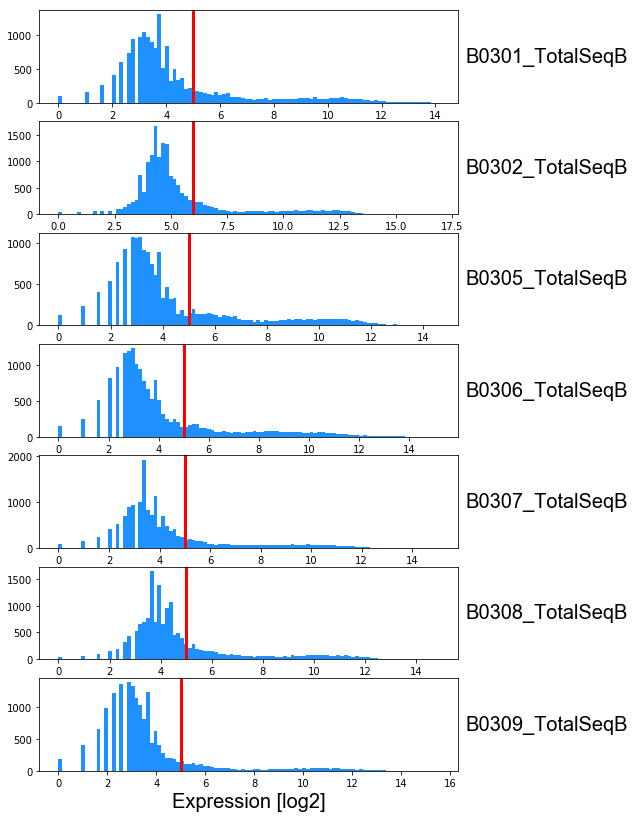

In [250]:
plot_hashes(pdH, thr = [5,6,5,5,5,5,5])

In [251]:
hashes_out = assign_hashes(pdH, [5,6,5,5,5,5,5])

In [252]:
X_XZ1450_20211210.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [253]:
X_XZ1450_20211210.obs['batch'] = 'XZ1450_20211210'
X_XZ1450_20211210.obs['sample'] = None
X_XZ1450_20211210.obs['mouse'] = None
X_XZ1450_20211210.obs['sex'] = None
X_XZ1450_20211210.obs['tumor'] = 'KPT'
X_XZ1450_20211210.obs['age'] = None
X_XZ1450_20211210.obs['tumor*age'] = None
X_XZ1450_20211210.obs['tumor_stage'] = '4wk'

In [254]:
sample_XZ1450_20211210 = {'B0301_TotalSeqB':'AD1151_KPT_aged',
                          'B0302_TotalSeqB':'AD1153_KPT_aged',
                          'B0305_TotalSeqB':'AO1127_KPT_young',
                          'B0306_TotalSeqB':'AC1705_KPT_aged',
                          'B0307_TotalSeqB':'AO1128_KPT_young',
                          'B0308_TotalSeqB':'AO1547_KPT_young',
                          'B0309_TotalSeqB':'AO1551_KPT_young'}

In [255]:
X_XZ1450_20211210.obs['sample'] = [sample_XZ1450_20211210[i] if i in sample_XZ1450_20211210 else 'fail' for i in X_XZ1450_20211210.obs['hashID']]

In [256]:
mouse_XZ1450_20211210 = {'B0301_TotalSeqB':'AD1151',
                         'B0302_TotalSeqB':'AD1153',
                         'B0305_TotalSeqB':'AO1127',
                         'B0306_TotalSeqB':'AC1705',
                         'B0307_TotalSeqB':'AO1128',
                         'B0308_TotalSeqB':'AO1547',
                         'B0309_TotalSeqB':'AO1551'}

In [257]:
X_XZ1450_20211210.obs['mouse'] = [mouse_XZ1450_20211210[i] if i in mouse_XZ1450_20211210 else 'fail' for i in X_XZ1450_20211210.obs['hashID']]

In [258]:
sex_XZ1450_20211210 = {'B0301_TotalSeqB':'F',
                         'B0302_TotalSeqB':'F',
                         'B0305_TotalSeqB':'F',
                         'B0306_TotalSeqB':'M',
                         'B0307_TotalSeqB':'F',
                         'B0308_TotalSeqB':'F',
                         'B0309_TotalSeqB':'F'}

In [259]:
X_XZ1450_20211210.obs['sex'] = [sex_XZ1450_20211210[i] if i in sex_XZ1450_20211210 else 'fail' for i in X_XZ1450_20211210.obs['hashID']]

In [260]:
age_XZ1450_20211210 = {'B0301_TotalSeqB':'aged',
                       'B0302_TotalSeqB':'aged',
                       'B0305_TotalSeqB':'young',
                       'B0306_TotalSeqB':'aged',
                       'B0307_TotalSeqB':'young',
                       'B0308_TotalSeqB':'young',
                       'B0309_TotalSeqB':'young'}

In [261]:
X_XZ1450_20211210.obs['age'] = [age_XZ1450_20211210[i] if i in age_XZ1450_20211210 else 'fail' for i in X_XZ1450_20211210.obs['hashID']]

In [262]:
X_XZ1450_20211210.obs['tumor*age'] = ['KPT_%s' % i for i in X_XZ1450_20211210.obs['age']]

In [263]:
Counter(X_XZ1450_20211210.obs['sample'])

Counter({'fail': 6884,
         'AO1128_KPT_young': 1600,
         'AO1551_KPT_young': 604,
         'AC1705_KPT_aged': 1473,
         'AD1153_KPT_aged': 1154,
         'AO1127_KPT_young': 1521,
         'AO1547_KPT_young': 1607,
         'AD1151_KPT_aged': 1470})

# XZ-1601_20220302

### Load data into AnnData format

In [264]:
_XZ1601_20220302 = sc.read_10x_mtx('%s/20220412_XZ-1601_20220302_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_XZ1601_20220302 .obs_names = [s.split('-')[0] for s in _XZ1601_20220302.obs_names]

In [265]:
_XZ1601_20220302.layers['raw'] = _XZ1601_20220302.X

In [266]:
X_XZ1601_20220302 = _XZ1601_20220302[:,:-9]

### Add transgene counts to metadata

In [267]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [268]:
X_XZ1601_20220302.obs[tgs] = X_XZ1601_20220302[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [269]:
X_XZ1601_20220302 = X_XZ1601_20220302[:,:-8]

### Assign hashes

In [270]:
hashes = ['B0301_TotalSeqB',
          'B0304_TotalSeqB',
          'B0310_TotalSeqB']

In [271]:
H_XZ1601_20220302 = _XZ1601_20220302[:,hashes]

In [272]:
pdH = sc2pd(H_XZ1601_20220302, 'X')

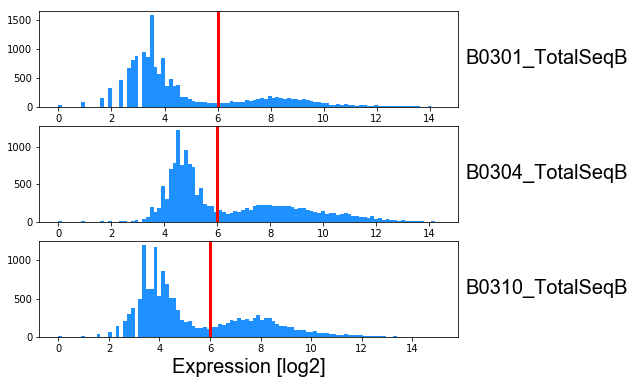

In [273]:
plot_hashes(pdH, thr = [6,6,6])

In [274]:
hashes_out = assign_hashes(pdH, [6,6,6])

In [275]:
X_XZ1601_20220302.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [276]:
X_XZ1601_20220302.obs['batch'] = 'XZ1601_20220302'
X_XZ1601_20220302.obs['sample'] = None
X_XZ1601_20220302.obs['mouse'] = None
X_XZ1601_20220302.obs['sex'] = None
X_XZ1601_20220302.obs['tumor'] = 'KPT'
X_XZ1601_20220302.obs['age'] = None
X_XZ1601_20220302.obs['tumor*age'] = None
X_XZ1601_20220302.obs['tumor_stage'] = '12wk'

In [277]:
sample_XZ1601_20220302 = {'B0301_TotalSeqB':'AD1257_KPT_aged',
                          'B0304_TotalSeqB':'AP1446_KPT_young',
                          'B0310_TotalSeqB':'AP1450_KPT_young'}

In [278]:
X_XZ1601_20220302.obs['sample'] = [sample_XZ1601_20220302[i] if i in sample_XZ1601_20220302 else 'fail' for i in X_XZ1601_20220302.obs['hashID']]

In [279]:
mouse_XZ1601_20220302 = {'B0301_TotalSeqB':'AD1257',
                          'B0304_TotalSeqB':'AP1446',
                          'B0310_TotalSeqB':'AP1450'}

In [280]:
X_XZ1601_20220302.obs['mouse'] = [mouse_XZ1601_20220302[i] if i in mouse_XZ1601_20220302 else 'fail' for i in X_XZ1601_20220302.obs['hashID']]

In [281]:
sex_XZ1601_20220302 = {'B0301_TotalSeqB':'M',
                          'B0304_TotalSeqB':'M',
                          'B0310_TotalSeqB':'F'}

In [282]:
X_XZ1601_20220302.obs['sex'] = [sex_XZ1601_20220302[i] if i in sex_XZ1601_20220302 else 'fail' for i in X_XZ1601_20220302.obs['hashID']]

In [283]:
age_XZ1601_20220302 = {'B0301_TotalSeqB':'aged',
                       'B0304_TotalSeqB':'young',
                       'B0310_TotalSeqB':'young'}

In [284]:
X_XZ1601_20220302.obs['age'] = [age_XZ1601_20220302[i] if i in age_XZ1601_20220302 else 'fail' for i in X_XZ1601_20220302.obs['hashID']]

In [285]:
X_XZ1601_20220302.obs['tumor*age'] = ['KPT_%s' % i for i in X_XZ1601_20220302.obs['age']]

In [286]:
Counter(X_XZ1601_20220302.obs['sample'])

Counter({'AP1446_KPT_young': 4797,
         'AP1450_KPT_young': 3989,
         'AD1257_KPT_aged': 2714,
         'fail': 3632})

# 2020-11-20_A_Y_LUAD

### Load data into AnnData format

In [287]:
_20201120_A_Y_LUAD = sc.read_10x_mtx('%s/20220429_2020-11-20_A_Y_LUAD_filtered_feature_bc_matrix' % path_input, make_unique=True, gex_only=False)
_20201120_A_Y_LUAD .obs_names = [s.split('-')[0] for s in _20201120_A_Y_LUAD.obs_names]

In [288]:
_20201120_A_Y_LUAD.layers['raw'] = _20201120_A_Y_LUAD.X

In [289]:
X_20201120_A_Y_LUAD = _20201120_A_Y_LUAD[:,:-9]

### Add transgene counts to metadata

In [290]:
tgs = ['FLuc', 'tdTomato', 'GFP', 'Cre', 'ERT','LoxP', 'mScarlet', 'Ova']

In [291]:
X_20201120_A_Y_LUAD.obs[tgs] = X_20201120_A_Y_LUAD[:,tgs].X.todense()

Trying to set attribute `.obs` of view, copying.


In [292]:
X_20201120_A_Y_LUAD = X_20201120_A_Y_LUAD[:,:-8]

### Assign hashes

In [293]:
hashes = ['B0301_TotalSeqB',
          'B0302_TotalSeqB',
          'B0303_TotalSeqB',
          'B0304_TotalSeqB',
          'B0305_TotalSeqB','B0306_TotalSeqB']

In [294]:
H_20201120_A_Y_LUAD = _20201120_A_Y_LUAD[:,hashes]

In [295]:
pdH = sc2pd(H_20201120_A_Y_LUAD, 'X')

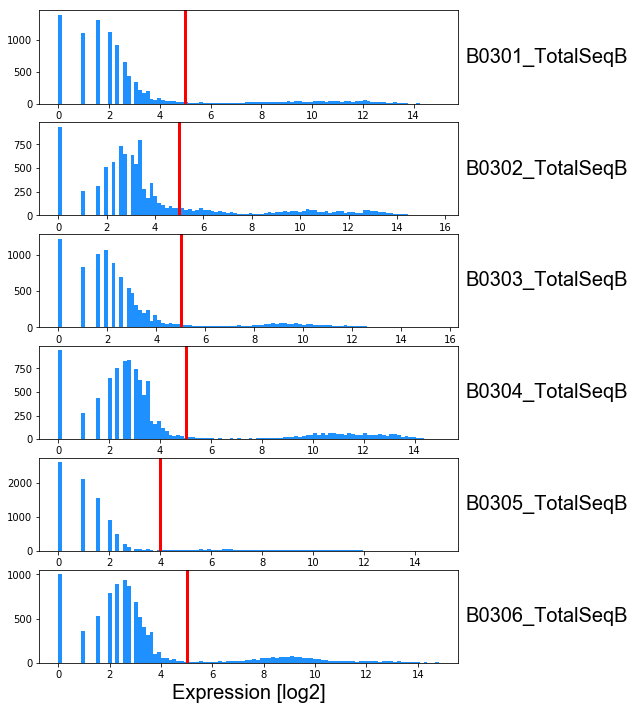

In [296]:
plot_hashes(pdH, thr = [5,5,5,5,4,5])

In [297]:
hashes_out = assign_hashes(pdH, [5,5,5,5,4,5])

In [298]:
X_20201120_A_Y_LUAD.obs['hashID'] = hashes_out

Trying to set attribute `.obs` of view, copying.


### Add metadata

In [299]:
X_20201120_A_Y_LUAD.obs['batch'] = '20201120_A_Y_LUAD'
X_20201120_A_Y_LUAD.obs['sample'] = None
X_20201120_A_Y_LUAD.obs['mouse'] = None
X_20201120_A_Y_LUAD.obs['sex'] = None
X_20201120_A_Y_LUAD.obs['tumor'] = None
X_20201120_A_Y_LUAD.obs['age'] = None
X_20201120_A_Y_LUAD.obs['tumor*age'] = None
X_20201120_A_Y_LUAD.obs['tumor_stage'] = '17-18wk'

In [300]:
sample_20201120_A_Y_LUAD = {'B0301_TotalSeqB':'AE1507_KP_young',
                          'B0302_TotalSeqB':'AE1509_KP_young',
                          'B0303_TotalSeqB':'AE1513_KP_young',
                          'B0304_TotalSeqB':'AE1517_KP_young',
                          'B0305_TotalSeqB':'GH2658_KPR_aged',
                          'B0306_TotalSeqB':'GH2662_KPR_aged'}

In [301]:
X_20201120_A_Y_LUAD.obs['sample'] = [sample_20201120_A_Y_LUAD[i] if i in sample_20201120_A_Y_LUAD else 'fail' for i in X_20201120_A_Y_LUAD.obs['hashID']]

In [302]:
mouse_20201120_A_Y_LUAD = {'B0301_TotalSeqB':'AE1507',
                          'B0302_TotalSeqB':'AE1509',
                          'B0303_TotalSeqB':'AE1513',
                          'B0304_TotalSeqB':'AE1517',
                          'B0305_TotalSeqB':'GH2658',
                          'B0306_TotalSeqB':'GH2662'}

In [303]:
X_20201120_A_Y_LUAD.obs['mouse'] = [mouse_20201120_A_Y_LUAD[i] if i in mouse_20201120_A_Y_LUAD else 'fail' for i in X_20201120_A_Y_LUAD.obs['hashID']]

In [304]:
sex_20201120_A_Y_LUAD = {'B0301_TotalSeqB':'M',
                          'B0302_TotalSeqB':'M',
                          'B0303_TotalSeqB':'F',
                          'B0304_TotalSeqB':'F',
                          'B0305_TotalSeqB':'F',
                          'B0306_TotalSeqB':'F'}

In [305]:
X_20201120_A_Y_LUAD.obs['sex'] = [sex_20201120_A_Y_LUAD[i] if i in sex_20201120_A_Y_LUAD else 'fail' for i in X_20201120_A_Y_LUAD.obs['hashID']]

In [306]:
tumor_20201120_A_Y_LUAD = {'B0301_TotalSeqB':'KP',
                          'B0302_TotalSeqB':'KP',
                          'B0303_TotalSeqB':'KP',
                          'B0304_TotalSeqB':'KP',
                          'B0305_TotalSeqB':'KPR',
                          'B0306_TotalSeqB':'KPR'}

In [307]:
X_20201120_A_Y_LUAD.obs['tumor'] = [tumor_20201120_A_Y_LUAD[i] if i in tumor_20201120_A_Y_LUAD else 'fail' for i in X_20201120_A_Y_LUAD.obs['hashID']]

In [308]:
age_20201120_A_Y_LUAD = {'B0301_TotalSeqB':'young',
                          'B0302_TotalSeqB':'young',
                          'B0303_TotalSeqB':'young',
                          'B0304_TotalSeqB':'young',
                          'B0305_TotalSeqB':'aged',
                          'B0306_TotalSeqB':'aged'}

In [309]:
X_20201120_A_Y_LUAD.obs['age'] = [age_20201120_A_Y_LUAD[i] if i in age_20201120_A_Y_LUAD else 'fail' for i in X_20201120_A_Y_LUAD.obs['hashID']]

In [310]:
X_20201120_A_Y_LUAD.obs['tumor*age'] = ['%s_%s' % (X_20201120_A_Y_LUAD.obs['tumor'][i], X_20201120_A_Y_LUAD.obs['age'][i]) for i in X_20201120_A_Y_LUAD.obs_names]

In [311]:
Counter(X_20201120_A_Y_LUAD.obs['sample'])

Counter({'AE1509_KP_young': 1303,
         'AE1507_KP_young': 684,
         'GH2658_KPR_aged': 1202,
         'GH2662_KPR_aged': 1319,
         'fail': 3038,
         'AE1513_KP_young': 1039,
         'AE1517_KP_young': 1337})

## Concatenate

In [312]:
X = X_GH2333_YoungHealthy.concatenate(X_KW1536_AgedHealthy,
                                      X_KW1537_AgedHealthy,
                                      X_Y07_YoungHealthy,
                                      X_20200826,
                                      X_20200901,
                                      X_XZ1450_20211210,
                                      X_XZ1344_20211018,
                                      X_XZ1345_20211019,
                                      X_XZ1601_20220302,
                                      X_GH1529_YoungTumor,
                                      X_SM8822_AgedTumor,
                                      X_AY_SPCCRE_LUAD,
                                      X_20201120_A_Y_LUAD,
                                      X_071020_A_YLUAD,
                                      X_071320_A_YLUAD,
                                      batch_key='concat', 
                                      index_unique='-',
                                      join='inner')

In [313]:
X.layers['raw'] = X.X

In [314]:
#X.X = X.X.todense()

In [315]:
np.shape(X)

(158002, 54838)

## Checkpoint

In [316]:
X.write_h5ad('%s/%s_LUAD_aging_raw.h5' % (path_output, exp_id))

... storing 'hashID' as categorical
... storing 'batch' as categorical
... storing 'sample' as categorical
... storing 'mouse' as categorical
... storing 'sex' as categorical
... storing 'tumor' as categorical
... storing 'age' as categorical
... storing 'tumor*age' as categorical
... storing 'tumor_stage' as categorical
... storing 'feature_types' as categorical


# Pre-processing - filtering

In [317]:
X = sc.read_h5ad('%s/%s_LUAD_aging_raw.h5' % (path_output, exp_id))

## Remove failed hashes (doublets, unmapped etc.)

In [318]:
c_sel = X.obs['sample'][X.obs['sample']!='fail'].index

In [319]:
len(c_sel)

115481

In [320]:
X = X[c_sel]

## Calculate QC metrics

In [321]:
X.var['mito'] = list(map(lambda x: x[:3] == 'mt-', X.var_names))

Trying to set attribute `.var` of view, copying.


In [322]:
sc.pp.calculate_qc_metrics(X, qc_vars = ['mito'], inplace = True)

## Plot sample specific yields

In [323]:
pdX = sc2pd(X, 'raw')

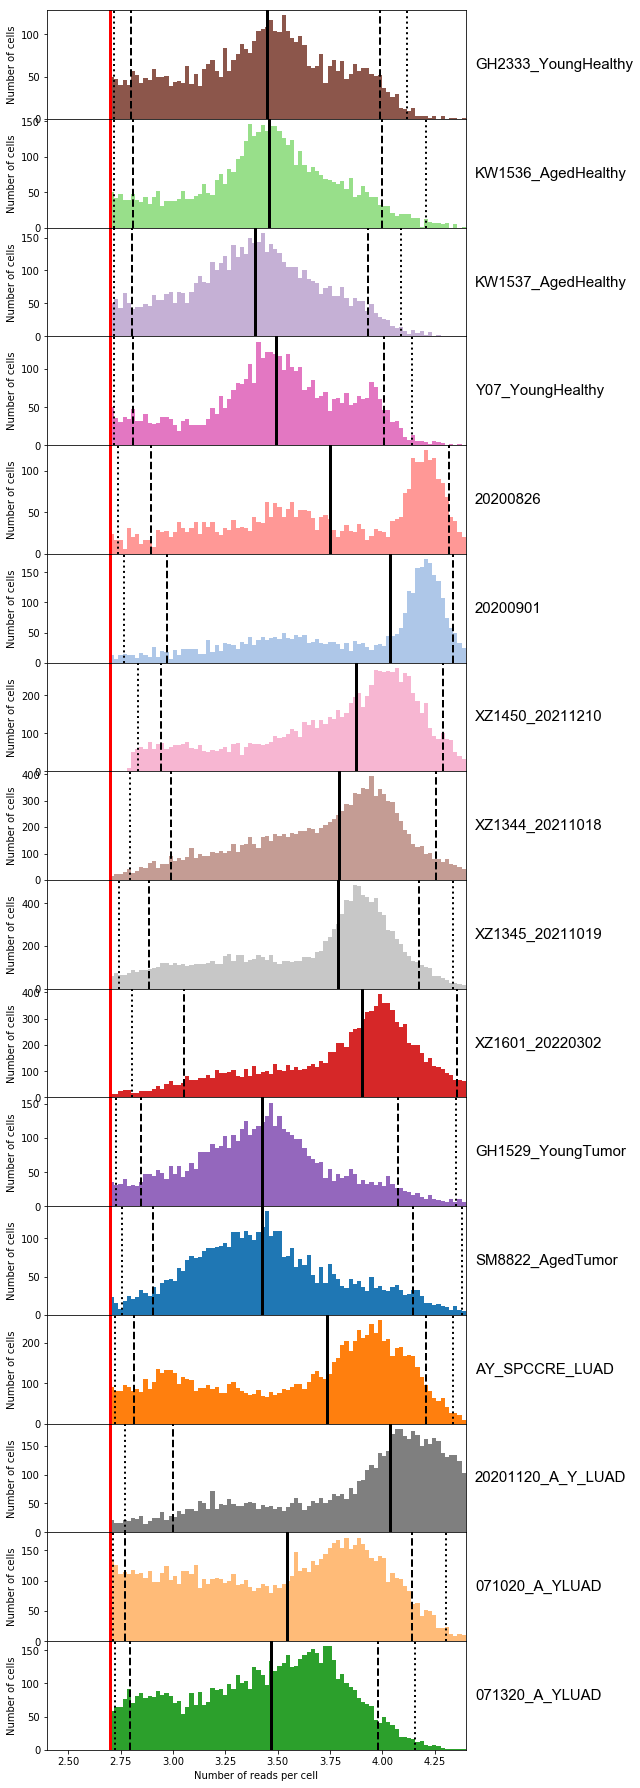

In [324]:
QC_hist(pdX,
        'reads',
        X.obs['batch'],
        log=True, xlim=(250,25000), thr = 500)

## Remove cells with less than 500 UMIs

In [326]:
c_sel = X.obs[X.obs['total_counts']>=500].index

In [327]:
len(c_sel)

115480

In [328]:
X = X[c_sel]

## Remove cells with more than 20% mitochondrial reads

In [329]:
c_sel = X.obs[X.obs['pct_counts_mito']<20].index

In [330]:
len(c_sel)

104731

In [331]:
X = X[c_sel]

## Remove low complexity / abundance cells

Trying to set attribute `.obs` of view, copying.


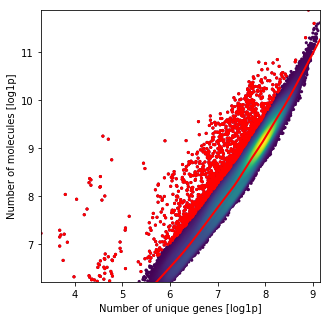

In [332]:
calculate_complexity(X, res_thr = 0.5, lowess_frac = 0.2)

In [333]:
c_sel = X.obs[X.obs['complexity_res']<0.5].index

In [334]:
len(c_sel)

102988

In [335]:
X = X[c_sel]

## Checkpoint

In [336]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

# Pre-processing - exploratory clustering of raw data

In [15]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

## log2 transformation

In [16]:
X.layers['raw_log2'] = scipy.sparse.csr_matrix(np.log2(X.X.todense()+1))

In [17]:
X.X = X.layers['raw_log2']

## Feature selection - gene filtering

In [18]:
g_sel = X.var[(X.var['mean_counts']>0.1) & (X.var['n_cells_by_counts']>(len(X.obs_names)*0.1))].index

In [19]:
len(g_sel)

6711

In [20]:
Xs = X[:,g_sel]

## Feature selection - VST

In [21]:
pdX = sc2pd(Xs, 'raw')

In [22]:
feat = select_features_vst(pdX, 1000)

In [23]:
Xs = Xs[:,feat]

## Dimensionality reduction - NMF

In [24]:
pdX = sc2pd(Xs, 'raw_log2')

In [25]:
nmf = dim_reduc(pdX, dim=50, method='NMF')

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [26]:
Xs.obsm['X_nmf'] = np.array(nmf).T

## k-nearest neighbors

In [27]:
sc.pp.neighbors(Xs, n_neighbors=25, n_pcs=50, use_rep='X_nmf', metric='euclidean')

## UMAP

In [28]:
sc.tl.umap(Xs, min_dist=0.5, spread=5)

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


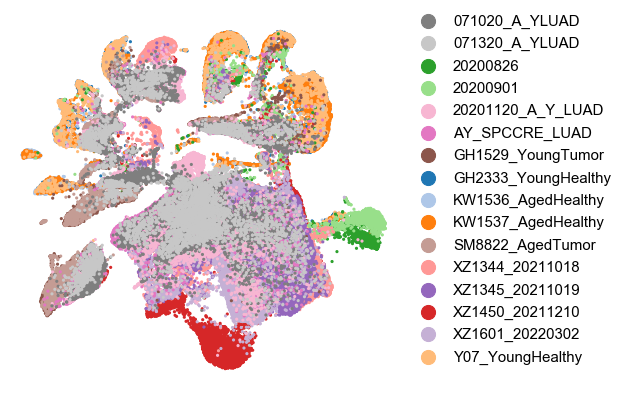

In [29]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['batch'],
                    s=10, show_axes=False)

In [30]:
pdX = sc2pd(X, 'raw_log2')

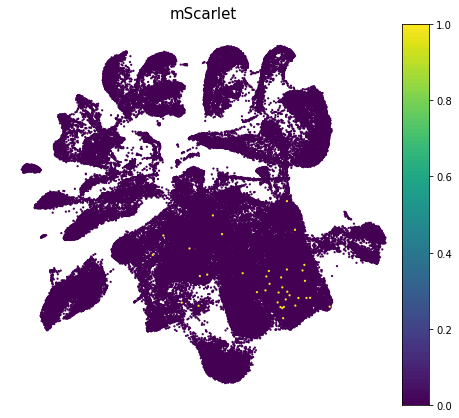

In [31]:
g = 'mScarlet'
expr = Xs.obs[g]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

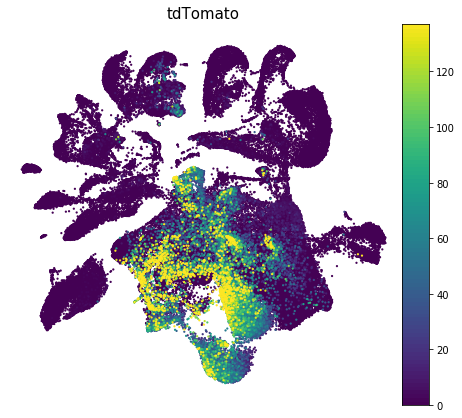

In [32]:
g = 'tdTomato'
expr = Xs.obs[g]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

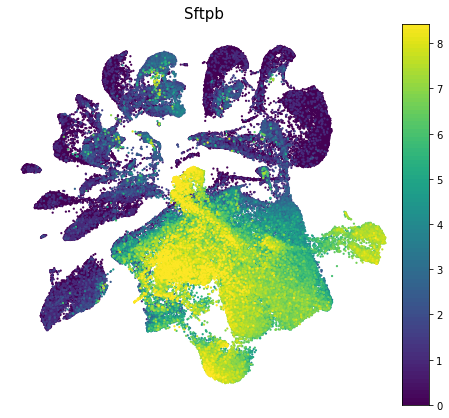

In [33]:
g = 'Sftpb'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

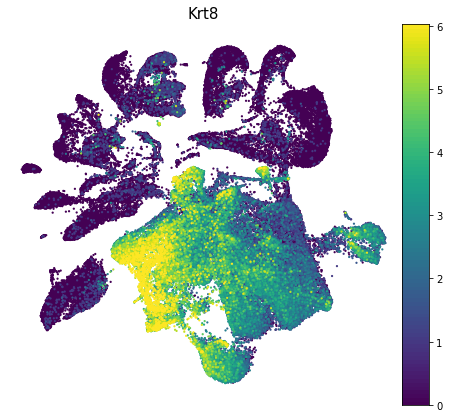

In [34]:
g = 'Krt8'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

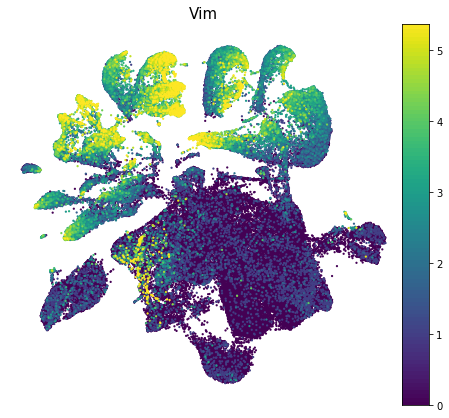

In [35]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

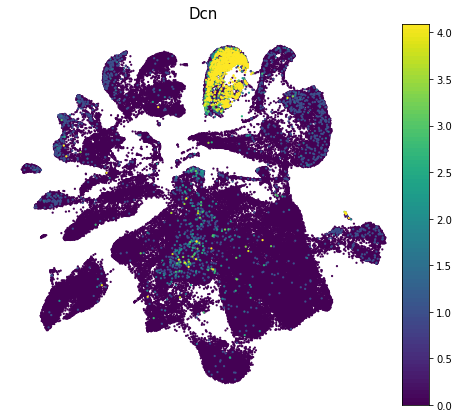

In [36]:
g = 'Dcn'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

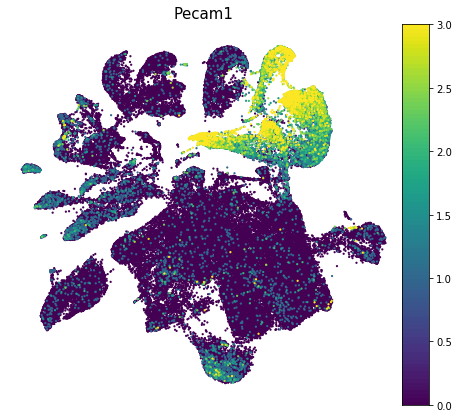

In [37]:
g = 'Pecam1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

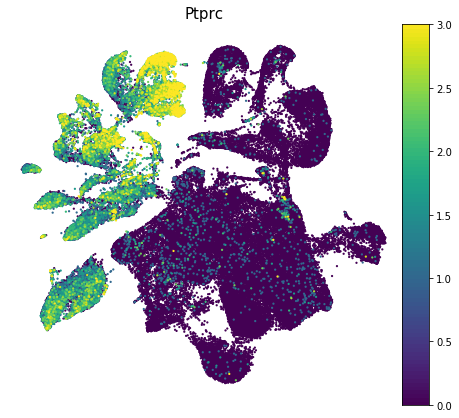

In [38]:
g = 'Ptprc'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

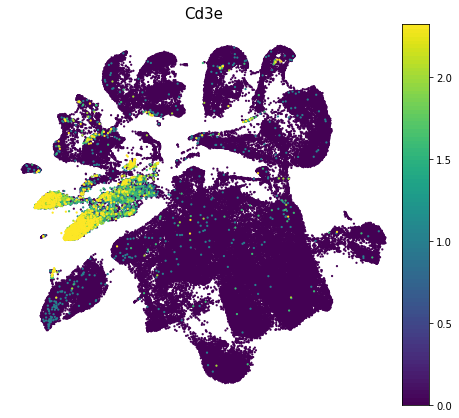

In [39]:
g = 'Cd3e'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

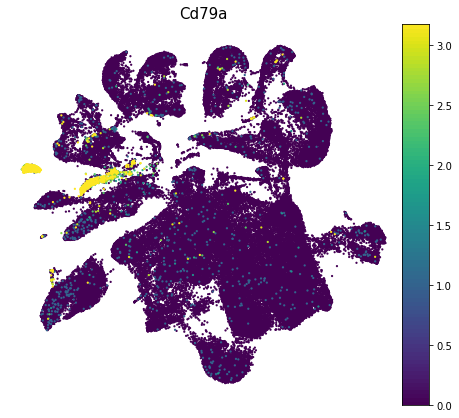

In [40]:
g = 'Cd79a'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

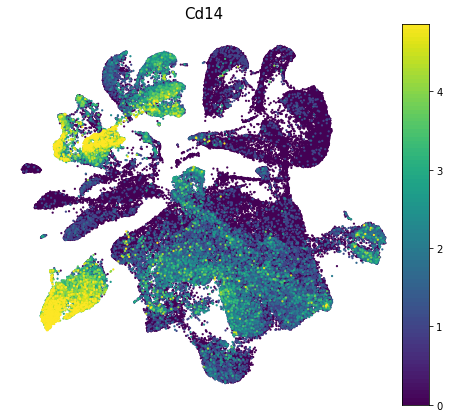

In [41]:
g = 'Cd14'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

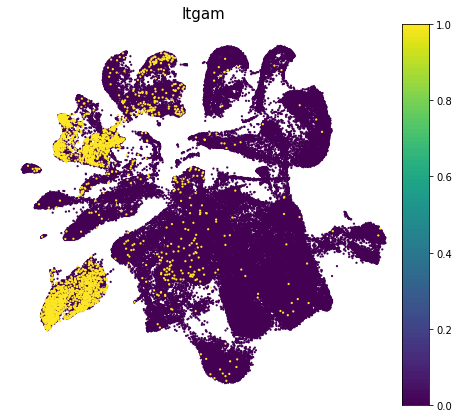

In [42]:
g = 'Itgam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs[pdX.columns].obsm['X_umap'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Leiden clustering

In [46]:
sc.tl.leiden(Xs, resolution = 0.15)

In [47]:
len(set(Xs.obs['leiden']))

13

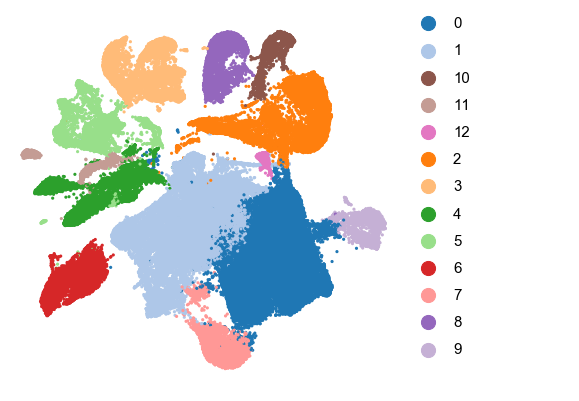

In [48]:
draw_scatter_groups(Xs.obsm['X_umap'], 
                    Xs.obs['leiden'],
                    cmap_tab20,
                    s=10, show_axes=False)

## Assign preliminary cluster identities

In [49]:
cl_pp = pd.Series('TUM', index = Xs.obs_names)

#macrophages
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin([])].index:
    cl_pp[c] = 'IMM-MC'
    
#T cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['4'])].index:
    cl_pp[c] = 'IMM-TC'
    
#B cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['11'])].index:
    cl_pp[c] = 'IMM-BC'
    
#Other immune cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['3','5','6'])].index:
    cl_pp[c] = 'IMM-OTHER'
    
#Fibroblasts
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['8'])].index:
    cl_pp[c] = 'FIB'
    
#Endothelial cells
    
for c in Xs.obs['leiden'][Xs.obs['leiden'].isin(['2','10'])].index:
    cl_pp[c] = 'ENDO'

In [50]:
X.obs['cl_pp'] = cl_pp
X.obsm['X_umap_pp'] = Xs.obsm['X_umap']

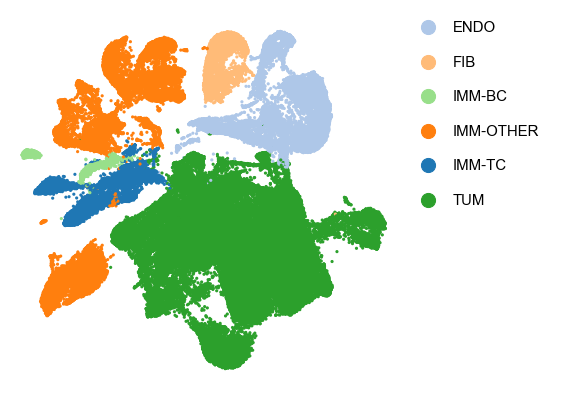

In [51]:
draw_scatter_groups(X.obsm['X_umap_pp'], 
                    X.obs['cl_pp'],
                    s=10, show_axes=False)

## Checkpoint

In [52]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

... storing 'cl_pp' as categorical


# Pre-processing - local filtering

In [53]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [54]:
pdX = sc2pd(X, 'raw')

## Total UMI distribution in clusters

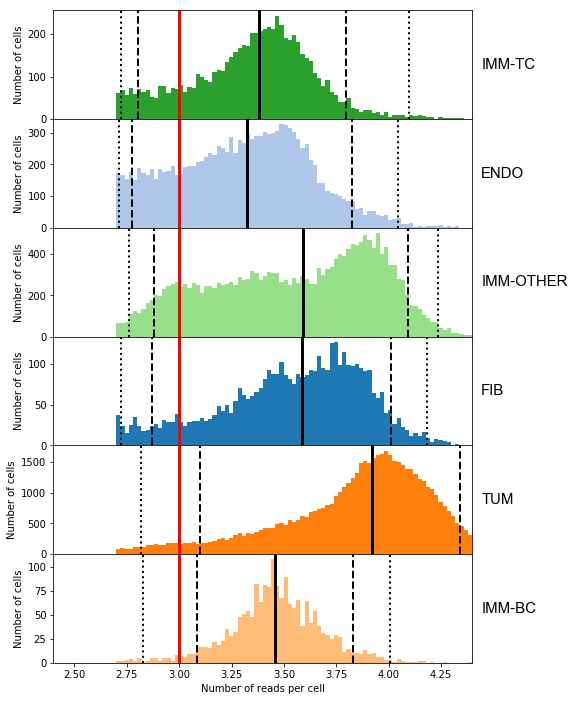

In [55]:
QC_hist(pdX,
        'reads',
        X.obs['cl_pp'],
        log=True, xlim=(250,25000), thr=1000)

## Remove cells with less than 1000 UMIs from FIB, ENDO, IMM-TC, IMM-BC

## Remove cells with less than 1500 UMIs from TUM, IMM-MC

In [57]:
c_sel1 = X.obs['cl_pp'][X.obs['cl_pp'].isin(['FIB','ENDO','IMM-TC','IMM-BC'])].index
c_sel2 = X.obs['cl_pp'][X.obs['cl_pp'].isin(['TUM','IMM-MC'])].index
c_sel3 = X.obs['cl_pp'][X.obs['cl_pp'].isin(['IMM-OTHER'])].index

In [58]:
print(len(c_sel1),len(c_sel2),len(c_sel3))

25488 56861 20639


In [59]:
c_sel1 = X.obs.loc[c_sel1][X.obs.loc[c_sel1]['total_counts']>=1000].index
c_sel2 = X.obs.loc[c_sel2][X.obs.loc[c_sel2]['total_counts']>=1500].index

In [60]:
len(c_sel1)

21448

In [61]:
len(c_sel2)

53258

In [62]:
X = X[list(c_sel1)+list(c_sel2)+list(c_sel3)]

## Checkpoint

In [63]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

# Pre-processing: Filter doublets with scrublet (Wolock et al. 2019)

In [64]:
import scrublet as scr

In [65]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

## Flag doublets

In [66]:
pdX = sc2pd(X, 'raw_log2')

In [67]:
X.obs['doublet_scores'] = None

for b in return_unique(X.obs['batch']):
    c_sel = X.obs['batch'][X.obs['batch']==b].index
    scrub = scr.Scrublet(pdX[c_sel].T)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    #scrub.plot_histogram()
    X.obs['doublet_scores'][c_sel] = doublet_scores

Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 62.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 7.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 55.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 4.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 62.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.9%
Elapsed time: 5.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 62.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 4.0 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 49.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 3.8 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 47.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 4.2 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 10.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 13.2 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 36.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 22.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 18.1 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.4%
Elapsed time: 15.6 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 42.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 5.3 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 42.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 4.8 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 45.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 15.7 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 34.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.4%
Elapsed time: 15.4 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 47.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 12.9 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing...


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 9.3 seconds


/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


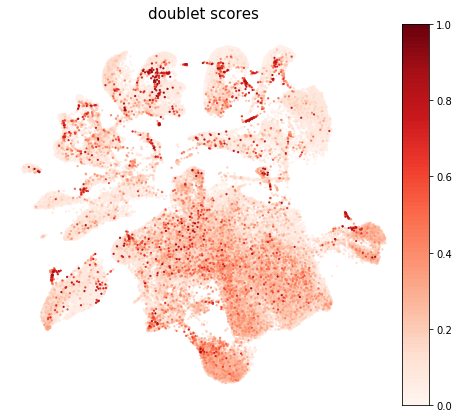

In [68]:
expr = X.obs['doublet_scores']
draw_scatter_expr(X[pdX.columns].obsm['X_umap_pp'],
                  expr,
                  0,
                  1,
                  cmap=plt.cm.Reds,
                  text = 'doublet scores',
                  s = 5, show_axes=False)

In [69]:
X.obs['doublets'] = X.obs['doublet_scores'] > 0.3

In [70]:
Counter(X.obs['doublets'])

Counter({False: 91916, True: 3429})

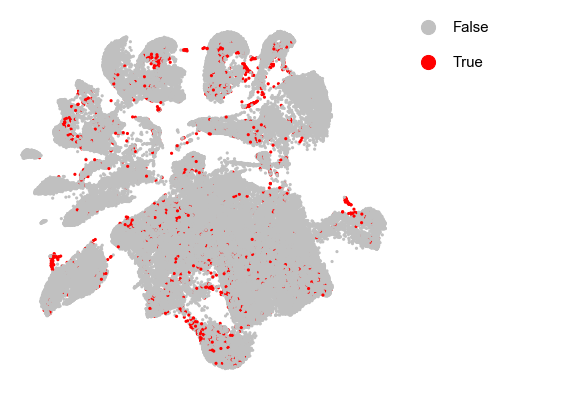

In [71]:
draw_scatter_groups(X.obsm['X_umap_pp'], 
                    X.obs['doublets'],
                    {False:'silver',True:'red'},
                    s=10,show_axes=False)

## Filter doublets

In [72]:
c_sel = X.obs['doublets'][X.obs['doublets']==False].index

In [73]:
len(c_sel)

91916

In [74]:
X = X[c_sel]

## Checkpoint

In [75]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'doublet_scores' as categorical


# Pre-processing: Size factor normalization (Lun method)

In [76]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

## Filter genes (mean expression: 0.1 molecules, expressed in at least 10% of cells)

In [77]:
g_sel = X.var[(X.var['mean_counts']>0.1) & (X.var['n_cells_by_counts']>(len(X.obs_names)*0.1))].index

In [78]:
len(g_sel)

6894

In [79]:
pdX_sel = sc2pd(X, 'raw').loc[g_sel]

## Divide dataset into random chunks to facilite calculation of size factors

In [80]:
barcodes = list(pdX_sel.columns)

In [81]:
np.random.shuffle(barcodes)

In [82]:
pdX_chunks = []

for chnk in chunks(barcodes, int(len(barcodes) / 4)+1):
    print(len(chnk))
    pdX_chunks.append(chnk)

22980
22980
22980
22976


## Run computeSumFactors in R

In [83]:
X.obs['size_factor'] = None

### Chunk 1

In [84]:
pdX_ = pdX_sel[pdX_chunks[0]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[0]]

In [85]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [86]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

/Users/simjoo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Chunk 2

In [87]:
pdX_ = pdX_sel[pdX_chunks[1]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[1]]

In [88]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [89]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

### Chunk 3

In [90]:
pdX_ = pdX_sel[pdX_chunks[2]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[2]]

In [91]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [92]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

### Chunk 4

In [93]:
pdX_ = pdX_sel[pdX_chunks[3]]
cl_pp_ = X.obs['cl_pp'][pdX_chunks[3]]

In [94]:
%%R -i pdX_ -i cl_pp_ -o sf

sce <- SingleCellExperiment(list(counts=as.matrix(pdX_)))
sce <- computeSumFactors(sce, cluster = cl_pp_)
sf <- sizeFactors(sce)

In [95]:
X.obs['size_factor'].loc[cl_pp_.index] = sf

## Checkpoint

In [96]:
X.obs['size_factor'] = X.obs['size_factor'].astype(float)

In [97]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

In [98]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))

## Remove cells with non-positive size factor and normalize

In [99]:
np.sum(X.obs['size_factor']<=0)

0

In [100]:
#solution from https://stackoverflow.com/questions/49254111/row-division-in-scipy-sparse-matrix

C = X.layers['raw'].copy()
D = np.array(X.obs['size_factor'])

In [101]:
val = np.repeat(D, C.getnnz(axis=1))
C.data /= val
X.layers['norm'] = C.copy()

In [102]:
C.data = np.log2(C.data + 1)
X.layers['norm_log2'] = C

In [103]:
pdX_sf = sc2pd(X, 'norm')

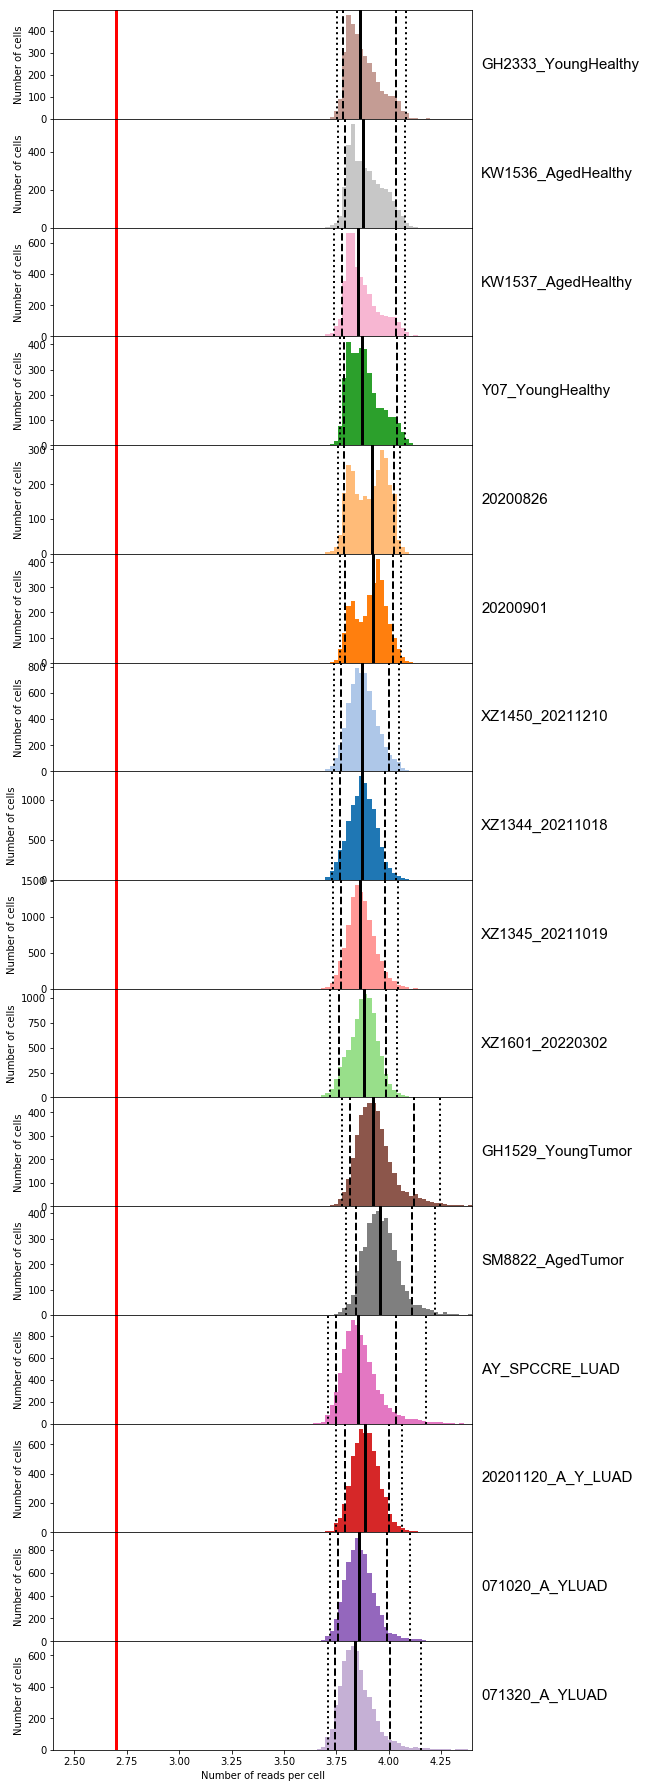

In [104]:
QC_hist(pdX_sf,
        'reads',
        X.obs['batch'],
        log=True, xlim=(250,25000), thr = 500)

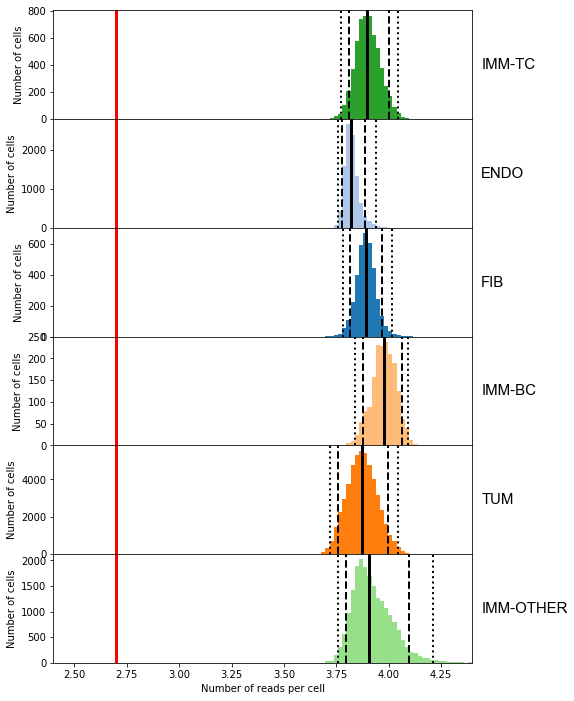

In [106]:
QC_hist(pdX_sf,
        'reads',
        X.obs['cl_pp'].loc[pdX_sf.columns],
        log=True, xlim=(250,25000), thr = 500)

## Checkpoint

In [107]:
X.write_h5ad('%s/%s_X_LUAD_aging_pp.h5' % (path_output, exp_id))